# Simple training example

### References
* https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html#learning-methods-on-graphs
* http://tkipf.github.io/graph-convolutional-networks/
* https://github.com/rusty1s/pytorch_geometric/tree/master/examples

In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch_geometric.utils.convert import to_networkx
from torch_geometric.datasets import Planetoid

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)
num_epochs = 200

Device: cpu


#### Load the Cora Citation dataset
Nodes represent documents and edges represent citation links. Training, validation and test splits are given by binary masks.

* https://arxiv.org/pdf/1603.08861.pdf

In [9]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')
print('LEN dataset_cora:', len(dataset))
data = dataset[0].to(device)

print('Number of classes:', dataset.num_classes)
print('Number of features per node:', dataset.num_node_features)
print('Number of nodes:', data.num_nodes)
print('Number of edges:', data.num_edges)
print('graph:', data)

LEN dataset_cora: 1
Number of classes: 7
Number of features per node: 1433
Number of nodes: 2708
Number of edges: 10556
graph: Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])


#### Define Network
This model will have 2 graph convolutional operator layers.

In [3]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 2 layers of spectral graph convolutions
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

model = Net().to(device)

#### Define Optimzier

In [4]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

#### Train Model

In [5]:
loss_vec = []
model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    loss_vec.append(loss.item())

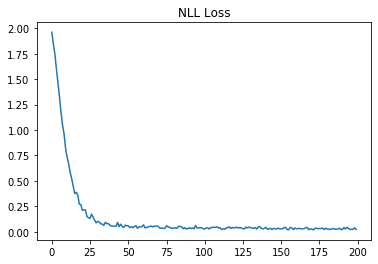

In [6]:
plt.plot(loss_vec)
plt.title('NLL Loss')
plt.show()

#### Evaluate

In [7]:
model.eval()
_, pred = model(data).max(dim=1)
correct = float (pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / data.test_mask.sum().item()
print('Accuracy: {:.4f}'.format(acc))

Accuracy: 0.7890


In [26]:
pred.shape

torch.Size([2708])

In [22]:
# Convert to networkx to plot
coragraph = to_networkx(data)

# Select labels
#node_labels = data.y[list(coragraph.nodes)].numpy()

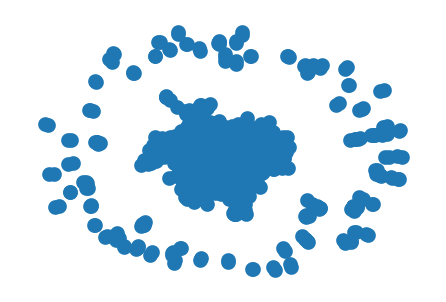

In [18]:
nx.draw(coragraph, cmap=plt.get_cmap('Set1'),node_size=75,linewidths=6)
plt.show()

In [23]:
data[data.test_mask]

TypeError: getattr(): attribute name must be string